# Projet Data Mining : Détection Heart Disease

# Importation des bibliothèques nécessaires

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix
import os
from sklearn.utils import resample

In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score

# Vision générale sur la dataset

une dataset contenant 319795 observations et 18 colonnes

In [3]:
df = pd.read_csv('heart_2020_cleaned.csv')
df

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319790,Yes,27.41,Yes,No,No,7.0,0.0,Yes,Male,60-64,Hispanic,Yes,No,Fair,6.0,Yes,No,No
319791,No,29.84,Yes,No,No,0.0,0.0,No,Male,35-39,Hispanic,No,Yes,Very good,5.0,Yes,No,No
319792,No,24.24,No,No,No,0.0,0.0,No,Female,45-49,Hispanic,No,Yes,Good,6.0,No,No,No
319793,No,32.81,No,No,No,0.0,0.0,No,Female,25-29,Hispanic,No,No,Good,12.0,No,No,No


elle ne contient pas de valeurs nulles

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  object 
 16  KidneyDisease     31

notre variable cible est : HeartDisease

# Exploratory Data Analysis

dans cette partie nous allons faire des analyses sur les différentes colonnes de notre dataset pour comprendre l'enjeu

ici nous avons afficher le nombre des cas qui sont atteint des maladies et qui ne le sont pas de notre variable cible: on remarque qu'il s'agit d'un cas de données désequilibrées, il faut appliquer donc les techniques de réechantillonage (nous allons l'appliquer lors du deploiement de nos modèles)

<AxesSubplot:xlabel='HeartDisease', ylabel='count'>

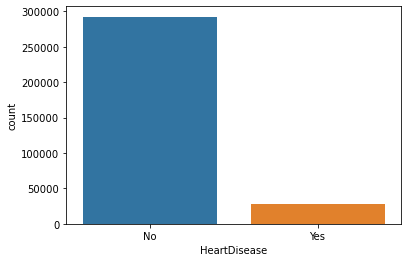

In [5]:
sns.countplot(x='HeartDisease',data=df)

In [6]:
df['HeartDisease'].value_counts()

No     292422
Yes     27373
Name: HeartDisease, dtype: int64

In [160]:
#nous allons explorer chaque attribut et essayer de comprendre son role et s'il impacte le résultat

**Race**

commençons par l'attribut Race, il s'agit d'une variable catégorique : elle indique la race des individus, on comprend directement qu'elle n'a aucun impacte sur la variable cible, il vaut mieux la supprimer

In [8]:
df['Race'].unique()

array(['White', 'Black', 'Asian', 'American Indian/Alaskan Native',
       'Other', 'Hispanic'], dtype=object)

In [9]:
df.drop(columns=['Race'], inplace=True)

**Smoking**

la variable smoking indique si l'individu fume ou pas

In [10]:
df['Smoking'].unique()

array(['Yes', 'No'], dtype=object)

<AxesSubplot:xlabel='Smoking', ylabel='count'>

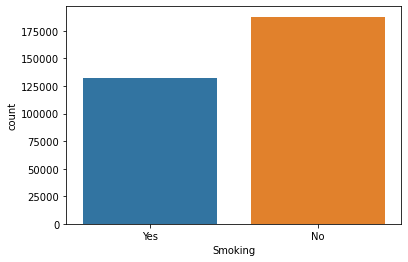

In [11]:
sns.countplot(x='Smoking',data=df)

In [12]:
df['Smoking'].value_counts()

No     187887
Yes    131908
Name: Smoking, dtype: int64

<AxesSubplot:xlabel='Smoking', ylabel='count'>

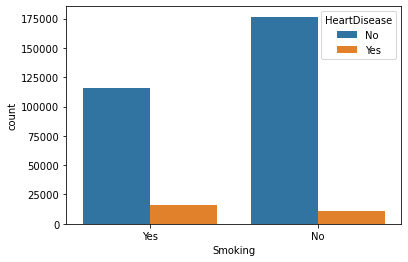

In [13]:
sns.countplot(x = 'Smoking' , data = df,hue='HeartDisease')

In [14]:
smoking_yes = df[(df['Smoking']=='Yes')]
smoking_no = df[(df['Smoking']=='No')]
print("HeartDisease *** smoking = Yes:   \n" + str(smoking_yes['HeartDisease'].value_counts()))
print('\n')
print("HeartDisease *** smoking = No:   \n" + str(smoking_no['HeartDisease'].value_counts()))

HeartDisease *** smoking = Yes:   
No     115871
Yes     16037
Name: HeartDisease, dtype: int64


HeartDisease *** smoking = No:   
No     176551
Yes     11336
Name: HeartDisease, dtype: int64


on remarque que le fait de fumer n'a pas un grand impact sur la variable cible puisque nous remarquons des individus qui fument et ne sont pas atteint des maladies de coeurs

**AlcoholDrinking**

Cette variable indique si l'individu consomment de l'alcohol ou pas, nous allons essayer de voir si boire de l'alcohol infecte la variable cible 

In [15]:
df['AlcoholDrinking'].unique()

array(['No', 'Yes'], dtype=object)

<AxesSubplot:xlabel='AlcoholDrinking', ylabel='count'>

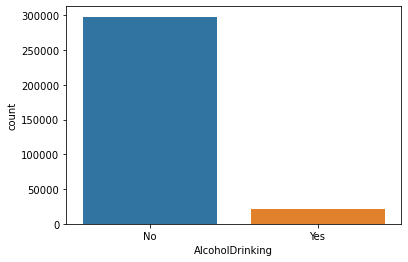

In [16]:
sns.countplot(x='AlcoholDrinking',data=df)

In [17]:
df['AlcoholDrinking'].value_counts()

No     298018
Yes     21777
Name: AlcoholDrinking, dtype: int64

<AxesSubplot:xlabel='AlcoholDrinking', ylabel='count'>

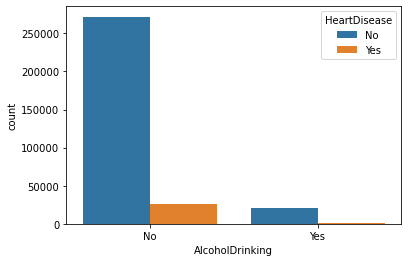

In [18]:
sns.countplot(x = 'AlcoholDrinking' , data = df,hue='HeartDisease')

In [19]:
alcohol_yes = df[(df['AlcoholDrinking']=='Yes')]
alcohol_no = df[(df['AlcoholDrinking']=='No')]
print("HeartDisease *** AlcoholDrinking = Yes:   \n" + str(alcohol_yes['HeartDisease'].value_counts()))
print('\n')
print("HeartDisease *** AlcoholDrinking = No:   \n" + str(alcohol_no['HeartDisease'].value_counts()))

HeartDisease *** AlcoholDrinking = Yes:   
No     20636
Yes     1141
Name: HeartDisease, dtype: int64


HeartDisease *** AlcoholDrinking = No:   
No     271786
Yes     26232
Name: HeartDisease, dtype: int64


même cas pour la varible AlcoholDrinking, le fait de boire n'a pas un grand impact sur la variable cible puisque nous remarquons des individus qui consomment de l'alcohol et ne sont pas atteint des maladies de coeurs

**Stroke**

Stroke : accident vasculaire cérébral, est ce que l'avc conduit à avoir des maladies cardiaques ?

In [20]:
df['Stroke'].unique()

array(['No', 'Yes'], dtype=object)

<AxesSubplot:xlabel='Stroke', ylabel='count'>

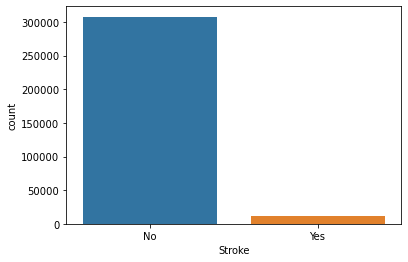

In [21]:
sns.countplot(x='Stroke',data=df)

In [22]:
df['Stroke'].value_counts()

No     307726
Yes     12069
Name: Stroke, dtype: int64

<AxesSubplot:xlabel='Stroke', ylabel='count'>

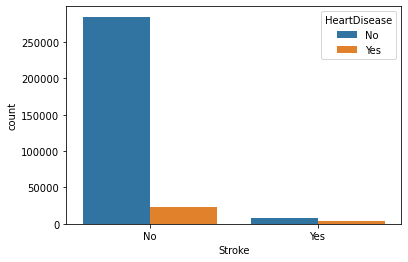

In [23]:
sns.countplot(x='Stroke', data=df, hue='HeartDisease')

In [24]:
stroke_yes = df[(df['Stroke']=='Yes')]
stroke_no = df[(df['Stroke']=='No')]
print("HeartDisease *** stroke = Yes:   \n" + str(stroke_yes['HeartDisease'].value_counts()))
print('\n')
print("HeartDisease *** stroke = No:   \n" + str(stroke_no['HeartDisease'].value_counts()))

HeartDisease *** stroke = Yes:   
No     7680
Yes    4389
Name: HeartDisease, dtype: int64


HeartDisease *** stroke = No:   
No     284742
Yes     22984
Name: HeartDisease, dtype: int64


même cas, cette variable n'a pas un grand impact sur la variable cible

**DiffWalking**

DiffWalking : difficulté de marcher, nous allons voir si les individus qui ont des difficultés de marcher sont plus susceptibles d'être atteint des maladies cardiaques

In [25]:
df['DiffWalking'].unique()

array(['No', 'Yes'], dtype=object)

<AxesSubplot:xlabel='DiffWalking', ylabel='count'>

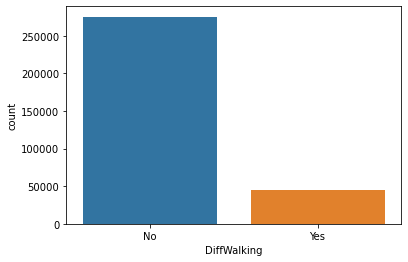

In [26]:
sns.countplot(x='DiffWalking',data=df)

In [27]:
df['DiffWalking'].value_counts()

No     275385
Yes     44410
Name: DiffWalking, dtype: int64

<AxesSubplot:xlabel='DiffWalking', ylabel='count'>

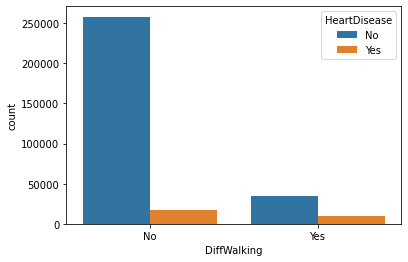

In [28]:
sns.countplot(x='DiffWalking', data=df, hue='HeartDisease')

In [29]:
diff_yes = df[(df['DiffWalking']=='Yes')]
diff_no = df[(df['DiffWalking']=='No')]
print("HeartDisease *** diffwalking = Yes:   \n" + str(diff_yes['HeartDisease'].value_counts()))
print('\n')
print("HeartDisease *** diffwalking = No:   \n" + str(diff_no['HeartDisease'].value_counts()))

HeartDisease *** diffwalking = Yes:   
No     34382
Yes    10028
Name: HeartDisease, dtype: int64


HeartDisease *** diffwalking = No:   
No     258040
Yes     17345
Name: HeartDisease, dtype: int64


cette variable n'a pas un grand impact sur la variable cible

**Sex**

In [30]:
df['Sex'].unique()

array(['Female', 'Male'], dtype=object)

<AxesSubplot:xlabel='Sex', ylabel='count'>

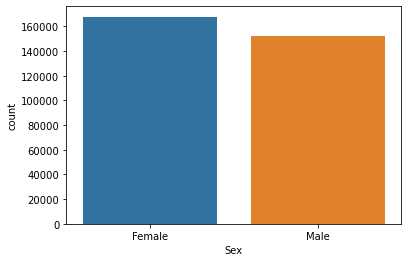

In [31]:
sns.countplot(x='Sex', data=df)

In [32]:
df['Sex'].value_counts()

Female    167805
Male      151990
Name: Sex, dtype: int64

<AxesSubplot:xlabel='Sex', ylabel='count'>

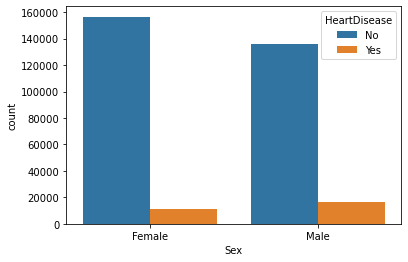

In [33]:
sns.countplot(x='Sex', data=df, hue='HeartDisease')

In [34]:
sex_male = df[(df['Sex']=='Male')]
sex_female = df[(df['Sex']=='Female')]
print("HeartDisease *** sex = Male:   \n" + str(sex_male['HeartDisease'].value_counts()))
print('\n')
print("HeartDisease *** sex = Female:   \n" + str(sex_female['HeartDisease'].value_counts()))

HeartDisease *** sex = Male:   
No     135851
Yes     16139
Name: HeartDisease, dtype: int64


HeartDisease *** sex = Female:   
No     156571
Yes     11234
Name: HeartDisease, dtype: int64


le sex n'a pas un grand effet sur la variable cible

**AgeCategory**

In [35]:
df['AgeCategory'].unique()

array(['55-59', '80 or older', '65-69', '75-79', '40-44', '70-74',
       '60-64', '50-54', '45-49', '18-24', '35-39', '30-34', '25-29'],
      dtype=object)

<AxesSubplot:xlabel='AgeCategory', ylabel='count'>

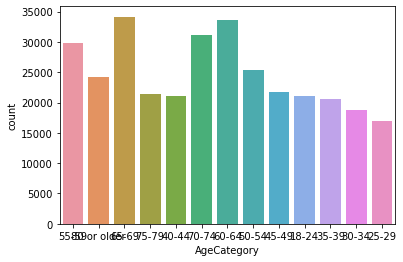

In [36]:
sns.countplot(x='AgeCategory', data=df)

<AxesSubplot:xlabel='AgeCategory', ylabel='count'>

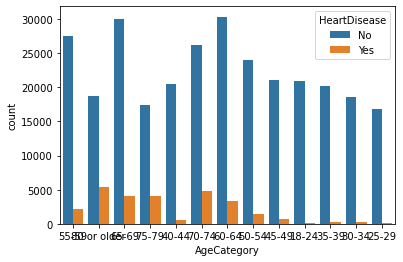

In [37]:
sns.countplot(x='AgeCategory', data=df, hue='HeartDisease')

**Diabetic**

In [38]:
df['Diabetic'].unique()

array(['Yes', 'No', 'No, borderline diabetes', 'Yes (during pregnancy)'],
      dtype=object)

<AxesSubplot:xlabel='Diabetic', ylabel='count'>

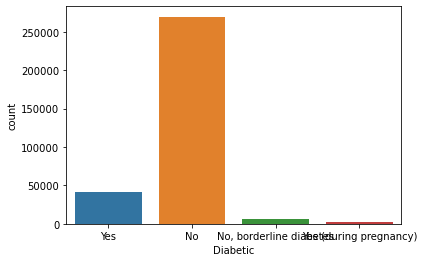

In [39]:
sns.countplot(x='Diabetic', data=df)

In [40]:
df['Diabetic'].value_counts()

No                         269653
Yes                         40802
No, borderline diabetes      6781
Yes (during pregnancy)       2559
Name: Diabetic, dtype: int64

<AxesSubplot:xlabel='Diabetic', ylabel='count'>

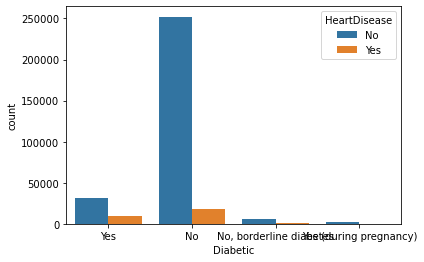

In [41]:
sns.countplot(x='Diabetic', data=df, hue='HeartDisease')

In [42]:
diabetic_yes = df[(df['Diabetic']=='Yes')]
diabetic_no = df[(df['Diabetic']=='No')]
borderline = df[(df['Diabetic']=='No, borderline diabetes')]
during_pregnacy = df[(df['Diabetic']=='Yes (during pregnancy)')]
print("HeartDisease *** diabetic = Yes:   \n" + str(diabetic_yes['HeartDisease'].value_counts()))
print('\n')
print("HeartDisease *** diabetic = No:   \n" + str(diabetic_no['HeartDisease'].value_counts()))
print('\n')
print("HeartDisease *** diabetic = No, borderline diabetes:   \n" + str(borderline['HeartDisease'].value_counts()))
print('\n')
print("HeartDisease *** diabetic = Yes (during pregnancy):   \n" + str(during_pregnacy['HeartDisease'].value_counts()))

HeartDisease *** diabetic = Yes:   
No     31845
Yes     8957
Name: HeartDisease, dtype: int64


HeartDisease *** diabetic = No:   
No     252134
Yes     17519
Name: HeartDisease, dtype: int64


HeartDisease *** diabetic = No, borderline diabetes:   
No     5992
Yes     789
Name: HeartDisease, dtype: int64


HeartDisease *** diabetic = Yes (during pregnancy):   
No     2451
Yes     108
Name: HeartDisease, dtype: int64


**PhysicalActivity**

In [44]:
df['PhysicalActivity'].unique()

array(['Yes', 'No'], dtype=object)

<AxesSubplot:xlabel='PhysicalActivity', ylabel='count'>

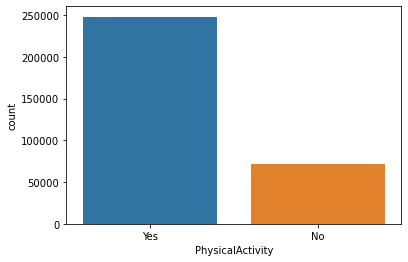

In [45]:
sns.countplot(x='PhysicalActivity', data=df)

In [46]:
df['PhysicalActivity'].value_counts()

Yes    247957
No      71838
Name: PhysicalActivity, dtype: int64

<AxesSubplot:xlabel='PhysicalActivity', ylabel='count'>

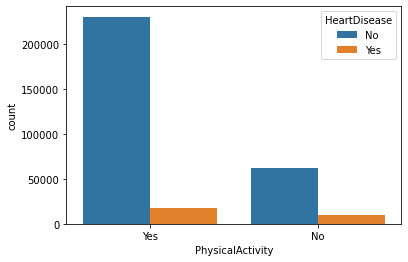

In [47]:
sns.countplot(x='PhysicalActivity', data=df, hue='HeartDisease')

In [48]:
physical_yes = df[(df['PhysicalActivity']=='Yes')]
physical_no = df[(df['PhysicalActivity']=='No')]
print("HeartDisease *** PhysicalActivity = Yes:   \n" + str(physical_yes['HeartDisease'].value_counts()))
print('\n')
print("HeartDisease *** PhysicalActivity = No:   \n" + str(physical_no['HeartDisease'].value_counts()))

HeartDisease *** PhysicalActivity = Yes:   
No     230468
Yes     17489
Name: HeartDisease, dtype: int64


HeartDisease *** PhysicalActivity = No:   
No     61954
Yes     9884
Name: HeartDisease, dtype: int64


**GenHealth**

In [49]:
df['GenHealth'].unique()

array(['Very good', 'Fair', 'Good', 'Poor', 'Excellent'], dtype=object)

<AxesSubplot:xlabel='GenHealth', ylabel='count'>

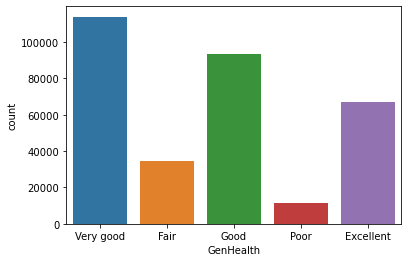

In [50]:
sns.countplot(x='GenHealth', data=df)

In [51]:
df['GenHealth'].value_counts()

Very good    113858
Good          93129
Excellent     66842
Fair          34677
Poor          11289
Name: GenHealth, dtype: int64

<AxesSubplot:xlabel='GenHealth', ylabel='count'>

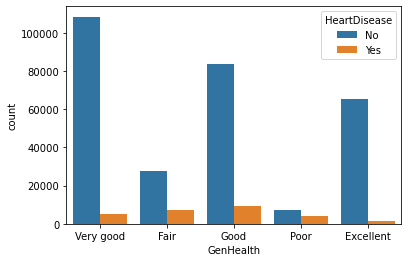

In [52]:
sns.countplot(x='GenHealth', data=df, hue='HeartDisease')

In [53]:
vg = df[(df['GenHealth']=='Very good')]
good = df[(df['GenHealth']=='Good')]
excellent = df[(df['GenHealth']=='Excellent')]
fair = df[(df['GenHealth']=='Fair')]
poor = df[(df['GenHealth']=='Poor')]
print("HeartDisease *** GenHealth = Very good:   \n" + str(vg['HeartDisease'].value_counts()))
print('\n')
print("HeartDisease *** GenHealth = Good:   \n" + str(good['HeartDisease'].value_counts()))
print('\n')
print("HeartDisease *** GenHealth = Excellent:   \n" + str(excellent['HeartDisease'].value_counts()))
print('\n')
print("HeartDisease *** GenHealth = Fair:   \n" + str(fair['HeartDisease'].value_counts()))
print('\n')
print("HeartDisease *** GenHealth = Poor:   \n" + str(poor['HeartDisease'].value_counts()))

HeartDisease *** GenHealth = Very good:   
No     108477
Yes      5381
Name: HeartDisease, dtype: int64


HeartDisease *** GenHealth = Good:   
No     83571
Yes     9558
Name: HeartDisease, dtype: int64


HeartDisease *** GenHealth = Excellent:   
No     65342
Yes     1500
Name: HeartDisease, dtype: int64


HeartDisease *** GenHealth = Fair:   
No     27593
Yes     7084
Name: HeartDisease, dtype: int64


HeartDisease *** GenHealth = Poor:   
No     7439
Yes    3850
Name: HeartDisease, dtype: int64


**Asthma**

In [54]:
df['Asthma'].unique()

array(['Yes', 'No'], dtype=object)

<AxesSubplot:xlabel='Asthma', ylabel='count'>

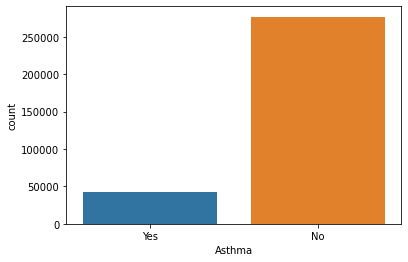

In [55]:
sns.countplot(x='Asthma', data=df)

In [56]:
df['Asthma'].value_counts()

No     276923
Yes     42872
Name: Asthma, dtype: int64

<AxesSubplot:xlabel='Asthma', ylabel='count'>

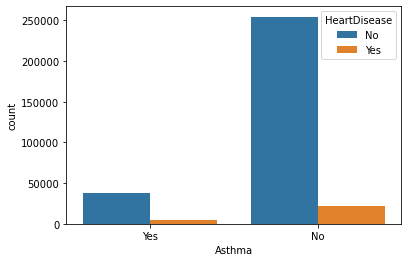

In [57]:
sns.countplot(x='Asthma', data=df, hue='HeartDisease')

In [58]:
asthma_yes = df[(df['Asthma']=='Yes')]
asthma_no = df[(df['Asthma']=='No')]
print("HeartDisease *** Asthma = Yes:   \n" + str(asthma_yes['HeartDisease'].value_counts()))
print('\n')
print("HeartDisease *** Asthma = No:   \n" + str(asthma_no['HeartDisease'].value_counts()))

HeartDisease *** Asthma = Yes:   
No     37939
Yes     4933
Name: HeartDisease, dtype: int64


HeartDisease *** Asthma = No:   
No     254483
Yes     22440
Name: HeartDisease, dtype: int64


**KidneyDisease**

In [59]:
df['KidneyDisease'].unique()

array(['No', 'Yes'], dtype=object)

<AxesSubplot:xlabel='KidneyDisease', ylabel='count'>

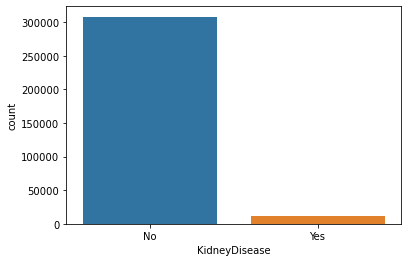

In [60]:
sns.countplot(x='KidneyDisease', data=df)

In [61]:
df['KidneyDisease'].value_counts()

No     308016
Yes     11779
Name: KidneyDisease, dtype: int64

<AxesSubplot:xlabel='KidneyDisease', ylabel='count'>

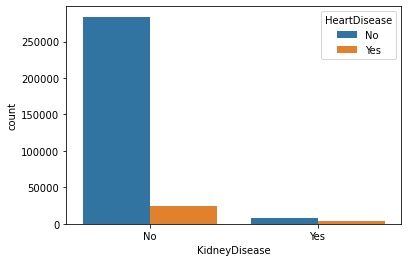

In [62]:
sns.countplot(x='KidneyDisease', data=df, hue='HeartDisease')

In [63]:
kidney_yes = df[(df['KidneyDisease']=='Yes')]
kidney_no = df[(df['KidneyDisease']=='No')]
print("HeartDisease *** KidneyDisease = Yes:   \n" + str(kidney_yes['HeartDisease'].value_counts()))
print('\n')
print("HeartDisease *** KidneyDisease = No:   \n" + str(kidney_no['HeartDisease'].value_counts()))

HeartDisease *** KidneyDisease = Yes:   
No     8324
Yes    3455
Name: HeartDisease, dtype: int64


HeartDisease *** KidneyDisease = No:   
No     284098
Yes     23918
Name: HeartDisease, dtype: int64


**SkinCancer**

In [64]:
df['SkinCancer'].unique()

array(['Yes', 'No'], dtype=object)

<AxesSubplot:xlabel='SkinCancer', ylabel='count'>

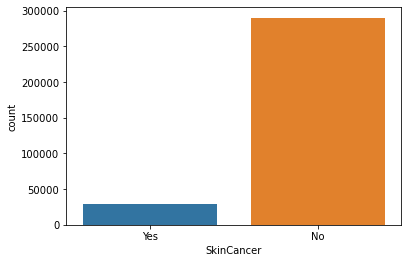

In [65]:
sns.countplot(x='SkinCancer', data=df)

In [66]:
df['SkinCancer'].value_counts()

No     289976
Yes     29819
Name: SkinCancer, dtype: int64

<AxesSubplot:xlabel='SkinCancer', ylabel='count'>

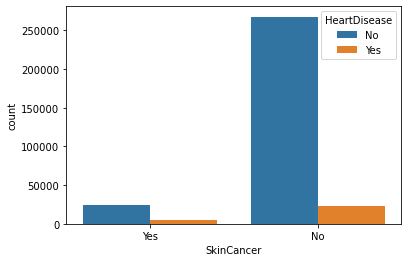

In [67]:
sns.countplot(x='SkinCancer', data=df, hue='HeartDisease')

In [68]:
skin_yes = df[(df['SkinCancer']=='Yes')]
skin_no = df[(df['SkinCancer']=='No')]
print("HeartDisease *** SkinCancer = Yes:   \n" + str(skin_yes['HeartDisease'].value_counts()))
print('\n')
print("HeartDisease *** SkinCancer = No:   \n" + str(skin_no['HeartDisease'].value_counts()))

HeartDisease *** SkinCancer = Yes:   
No     24839
Yes     4980
Name: HeartDisease, dtype: int64


HeartDisease *** SkinCancer = No:   
No     267583
Yes     22393
Name: HeartDisease, dtype: int64


en général, les variables catégoriques n'impactent pas la variable cible

nous allons maintenant essayer d'explorer les valeurs numériques et traiter les valeurs abbérantes

In [69]:
df.describe()

,BMI,PhysicalHealth,MentalHealth,SleepTime
count,319795.000000,319795.00000,319795.000000,319795.000000
mean,28.325399,3.37171,3.898366,7.097075
std,6.356100,7.95085,7.955235,1.436007
min,12.020000,0.00000,0.000000,1.000000
25%,24.030000,0.00000,0.000000,6.000000
50%,27.340000,0.00000,0.000000,7.000000
75%,31.420000,2.00000,3.000000,8.000000
max,94.850000,30.00000,30.000000,24.000000


**BMI**

In [70]:
len(df['BMI'].unique())

3604

(array([1.72840e+04, 1.72106e+05, 1.00863e+05, 2.33270e+04, 4.88800e+03,
        9.37000e+02, 2.61000e+02, 8.70000e+01, 2.90000e+01, 1.30000e+01]),
 array([12.02 , 20.303, 28.586, 36.869, 45.152, 53.435, 61.718, 70.001,
        78.284, 86.567, 94.85 ]),
 <BarContainer object of 10 artists>)

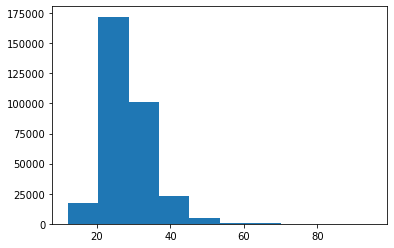

In [71]:
plt.hist(df['BMI'])

<AxesSubplot:xlabel='HeartDisease', ylabel='BMI'>

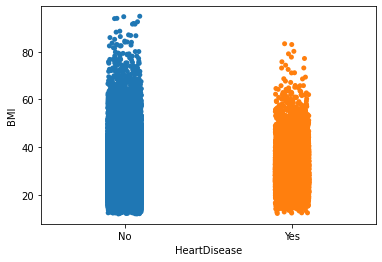

In [72]:
sns.stripplot(x = 'HeartDisease', y ='BMI', data = df)

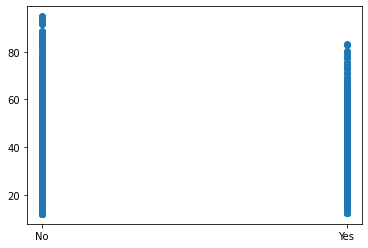

In [73]:
plt.scatter(df["HeartDisease"],df["BMI"])

C:\Users\Marouane\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='BMI'>

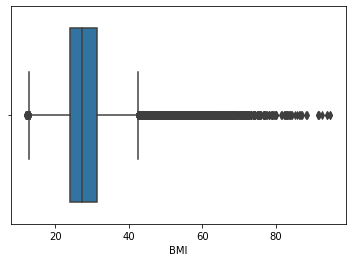

In [75]:
sns.boxplot(df['BMI'])

In [76]:
Q1 = df["BMI"].quantile(0.25)
Q3 = df["BMI"].quantile(0.75)
IQR = Q3 - Q1
Lower_Fence = Q1 - (1.5 * IQR)
Upper_Fence = Q3 + (1.5 * IQR)

In [77]:
Lower_Fence, Upper_Fence

(12.945, 42.505)

on remarque qu'il existe des valeurs abberantes pour la variable BMI (supérieur à Upper_Fence), il faut les supprimer

In [78]:
df[df['BMI']>42.505].shape

(10351, 17)

In [80]:
df = df.drop(df[df['BMI']>42.505].index)
df.shape

(309444, 17)

**PhysicalHealth**

In [81]:
len(df['PhysicalHealth'].unique())

31

(array([245833.,  19676.,   6531.,   5383.,   3409.,   4852.,   3154.,
           712.,   1193.,  18701.]),
 array([ 0.,  3.,  6.,  9., 12., 15., 18., 21., 24., 27., 30.]),
 <BarContainer object of 10 artists>)

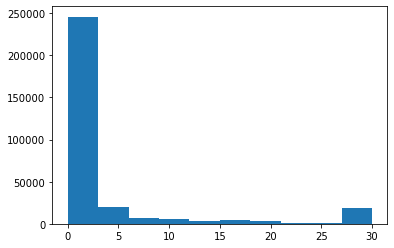

In [82]:
plt.hist(df['PhysicalHealth'])

<AxesSubplot:xlabel='HeartDisease', ylabel='PhysicalHealth'>

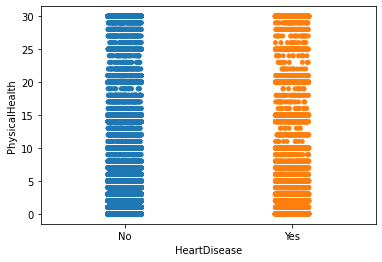

In [83]:
sns.stripplot(x = 'HeartDisease', y ='PhysicalHealth', data = df)

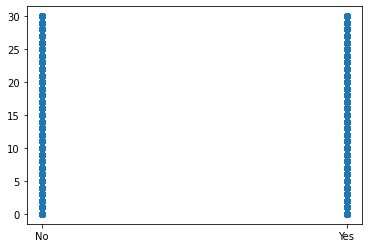

In [84]:
plt.scatter(df["HeartDisease"],df["PhysicalHealth"])

C:\Users\Marouane\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='PhysicalHealth'>

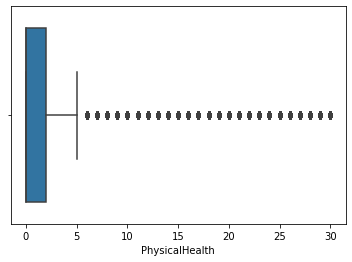

In [86]:
sns.boxplot(df['PhysicalHealth'])

In [87]:
Q1 = df["PhysicalHealth"].quantile(0.25)
Q3 = df["PhysicalHealth"].quantile(0.75)
IQR = Q3 - Q1
Lower_Fence = Q1 - (1.5 * IQR)
Upper_Fence = Q3 + (1.5 * IQR)
Lower_Fence, Upper_Fence

(-3.0, 5.0)

on remarque qu'il existe des valeurs abberantes pour la variable PhysicalHealth (supérieur à Upper_Fence), il faut les supprimer

In [88]:
df[df['PhysicalHealth']>5].shape

(43935, 17)

In [90]:
df = df.drop(df[df['PhysicalHealth']>5].index)
df.shape

(265509, 17)

**MentalHealth**

In [91]:
len(df['MentalHealth'].unique())

31

(array([203038.,  24714.,   6424.,   7904.,   1960.,   6843.,   3434.,
           296.,   1223.,   9673.]),
 array([ 0.,  3.,  6.,  9., 12., 15., 18., 21., 24., 27., 30.]),
 <BarContainer object of 10 artists>)

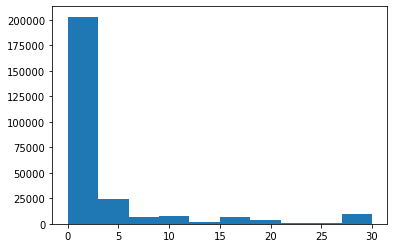

In [92]:
plt.hist(df['MentalHealth'])

<AxesSubplot:xlabel='HeartDisease', ylabel='MentalHealth'>

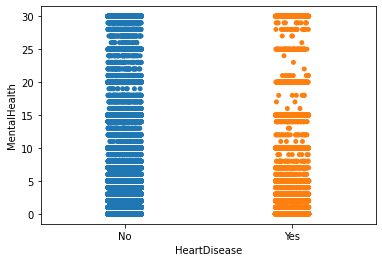

In [93]:
sns.stripplot(x = 'HeartDisease', y ='MentalHealth', data = df)

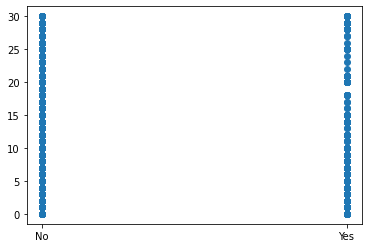

In [94]:
plt.scatter(df["HeartDisease"],df["MentalHealth"])

C:\Users\Marouane\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='MentalHealth'>

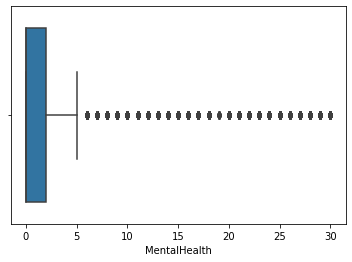

In [96]:
sns.boxplot(df['MentalHealth'])

In [97]:
Q1 = df["MentalHealth"].quantile(0.25)
Q3 = df["MentalHealth"].quantile(0.75)
IQR = Q3 - Q1
Lower_Fence = Q1 - (1.5 * IQR)
Upper_Fence = Q3 + (1.5 * IQR)
Lower_Fence, Upper_Fence

(-3.0, 5.0)

on remarque qu'il existe des valeurs abberantes pour la variable MentalHealth (supérieur à Upper_Fence), il faut les supprimer

In [98]:
df[df['MentalHealth']>7.5].shape

(32160, 17)

In [99]:
len([i for i in df['MentalHealth'].unique() if i>7.5])

23

In [101]:
df.shape

(233349, 17)

**SleepTime**

In [102]:
len(df['SleepTime'].unique())

24

(array([1.41300e+03, 1.36750e+04, 1.23143e+05, 9.33350e+04, 1.33900e+03,
        1.54000e+02, 2.03000e+02, 3.90000e+01, 3.00000e+01, 1.80000e+01]),
 array([ 1. ,  3.3,  5.6,  7.9, 10.2, 12.5, 14.8, 17.1, 19.4, 21.7, 24. ]),
 <BarContainer object of 10 artists>)

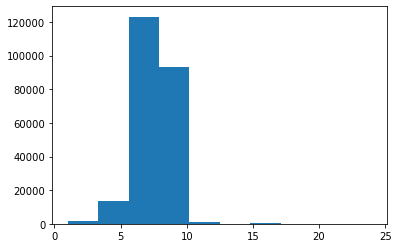

In [103]:
plt.hist(df['SleepTime'])

<AxesSubplot:xlabel='HeartDisease', ylabel='SleepTime'>

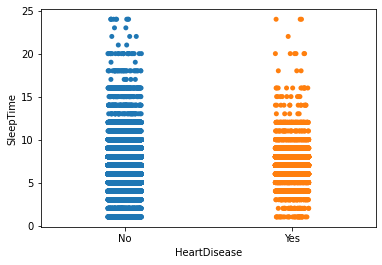

In [104]:
sns.stripplot(x = 'HeartDisease', y ='SleepTime', data = df)

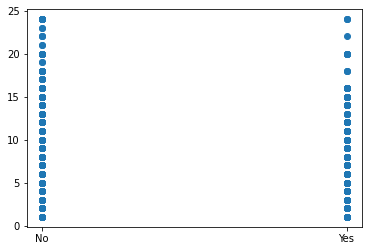

In [105]:
plt.scatter(df["HeartDisease"],df["SleepTime"])

C:\Users\Marouane\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='SleepTime'>

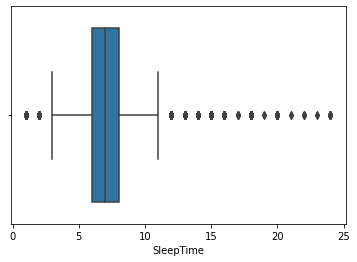

In [107]:
sns.boxplot(df['SleepTime'])

In [108]:
Q1 = df["SleepTime"].quantile(0.25)
Q3 = df["SleepTime"].quantile(0.75)
IQR = Q3 - Q1
Lower_Fence = Q1 - (1.5 * IQR)
Upper_Fence = Q3 + (1.5 * IQR)
Lower_Fence, Upper_Fence

(3.0, 11.0)

on remarque qu'il existe des valeurs abberantes pour la variable SleepTime (supérieur à Upper_Fence et inférieur à Lower_Fence), il faut les supprimer

In [110]:
df = df.drop(df[(df['SleepTime']>Upper_Fence) | (df['SleepTime']<Lower_Fence)].index)

In [111]:
df.shape

(231051, 17)

calcul de la corrélation entre les variables

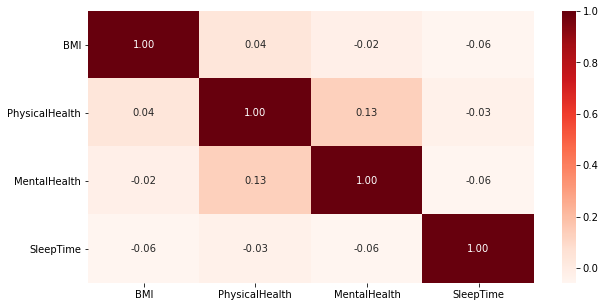

In [113]:
plt.figure(figsize=(10,5))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds, fmt='.2f')
plt.show()

il n'y a pas de forte corrélation entre ces variables

# Data preprocessing

Premièrement, nous allons transformer les variables catégoriques en numériques

Nous allons remplacer les variables de 'No', 'Yes' par {'No':0, 'Yes':1}

In [114]:
binary_yes_and_no = ['HeartDisease', 'Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'PhysicalActivity',
                       'Asthma', 'KidneyDisease', 'SkinCancer']

binary_values = {'No':0, 'Yes':1}
for i in range(0, len(binary_yes_and_no)):
    df[binary_yes_and_no[i]] = df[binary_yes_and_no[i]].replace(binary_values)

In [115]:
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
1,0,20.34,0,0,1,0.0,0.0,0,Female,80 or older,No,1,Very good,7.0,0,0,0
3,0,24.21,0,0,0,0.0,0.0,0,Female,75-79,No,0,Good,6.0,0,0,1
7,0,31.64,1,0,0,5.0,0.0,1,Female,80 or older,Yes,0,Good,9.0,1,0,0
8,0,26.45,0,0,0,0.0,0.0,0,Female,80 or older,"No, borderline diabetes",0,Fair,5.0,0,1,0
9,0,40.69,0,0,0,0.0,0.0,1,Male,65-69,No,1,Good,10.0,0,0,0


on remplace les valeurs de la variable sex par {'Female':0, 'Male':1}

In [116]:
sex = {'Female':0, 'Male':1}
df['Sex'] = df['Sex'].replace(sex)

In [117]:
df['Sex'].unique()

array([0, 1], dtype=int64)

Pour la variable GenHealth il faut spécifier le niveau de chaque valeur, il s'agit de la technique du LabelEncoding

In [118]:
levels = {'Poor':0, 'Fair':1, 'Good':2, 'Very good':3, 'Excellent':4}
df['GenHealth'] = df['GenHealth'].replace(levels)

In [119]:
df['GenHealth'].unique()

array([3, 2, 1, 4, 0], dtype=int64)

Même cas pour la variable du niveau de Diabetic

In [120]:
levels = {'No':0, 'No, borderline diabetes':1, 'Yes (during pregnancy)':2, 'Yes':3}
df['Diabetic'] = df['Diabetic'].replace(levels)

In [121]:
df['Diabetic'].unique()

array([0, 3, 1, 2], dtype=int64)

Pour le cas de la catégorieAge, nous allons regrouper les catégories d'ages en 6 catégories en appliquant le LabelEncoding

In [122]:
age= {'18-24':0, '25-29':0, '30-34':1, '35-39':1, '40-44':2, '45-49':2, '50-54':3, '55-59':3, '60-64':4, '65-69':4, '70-74':5, '75-79':5, '80 or older':6}
df['AgeCategory'] = df['AgeCategory'].replace(age)

In [123]:
df['AgeCategory'].unique()

array([6, 5, 4, 3, 2, 0, 1], dtype=int64)

On recalcule la corrélation après avoir transformé les variables catégoriques en numériques, on remarque qu'il y a des corrélations petites jusqu'à moyennes

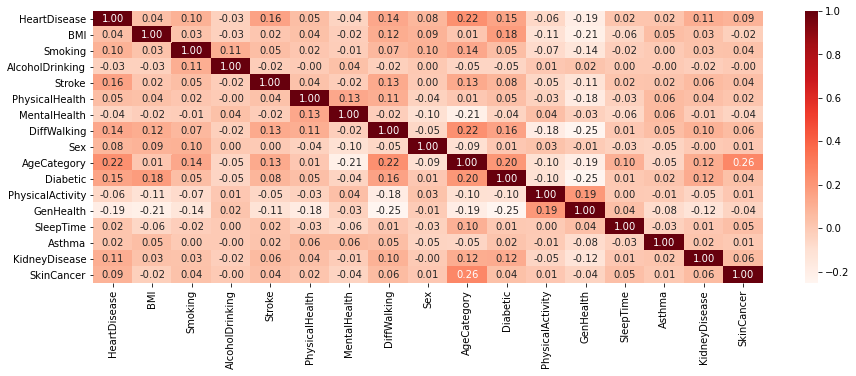

In [124]:
plt.figure(figsize=(15,5))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds, fmt='.2f')
plt.show()

Maintenant on va traiter la variable cible HeartDisease puisqu'il s'agit d'un cas de données désequilibrés, nous allons utiliser le réechantillonnage

In [126]:
df['HeartDisease'].value_counts()

0    215188
1     15863
Name: HeartDisease, dtype: int64

In [127]:
df_majority_0 = df[(df['HeartDisease']==0)] 
df_minority_1 = df[(df['HeartDisease']==1)] 

df_minority_upsampled = resample(df_minority_1, 
                                 replace=True,    
                                 n_samples= 215188, 
                                 random_state=42) 

df_upsampled = pd.concat([df_minority_upsampled, df_majority_0])

In [128]:
df_upsampled['HeartDisease'].value_counts()

0    215188
1    215188
Name: HeartDisease, dtype: int64

In [129]:
df_upsampled

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
148041,1,30.18,1,0,0,0.0,5.0,0,0,3,0,0,3,6.0,0,0,0
318093,1,27.43,0,0,0,0.0,0.0,0,1,0,0,0,4,6.0,0,0,0
16476,1,36.61,1,0,0,0.0,0.0,0,1,5,3,0,2,8.0,0,1,0
108645,1,26.79,1,1,0,2.0,0.0,0,0,4,0,0,2,7.0,0,0,0
268113,1,28.06,1,0,0,0.0,0.0,1,0,4,0,0,1,6.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319785,0,31.93,0,1,0,0.0,0.0,0,1,4,0,1,2,7.0,0,0,0
319788,0,23.38,0,0,0,0.0,0.0,0,0,4,0,1,4,6.0,0,0,0
319789,0,22.22,0,0,0,0.0,0.0,0,0,0,0,1,4,8.0,0,0,0
319791,0,29.84,1,0,0,0.0,0.0,0,1,1,0,1,3,5.0,1,0,0


calcul de corrélation après reéechantillonnage

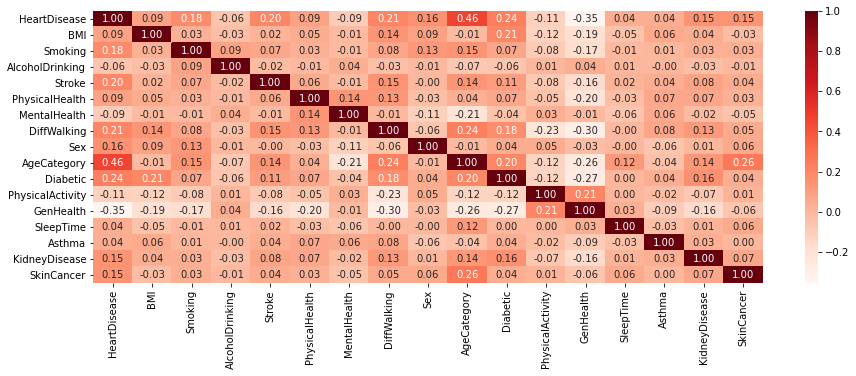

In [130]:
plt.figure(figsize=(15,5))
cor = df_upsampled.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds, fmt='.2f')
plt.show()

# Déploiement du modèle

Division du dataset en deux parties : Train et Test

In [131]:
X = df_upsampled.drop(columns='HeartDisease')
y = df_upsampled['HeartDisease']

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.95, shuffle=True)

Utilisation du modèle XGBoost

In [133]:
from xgboost import XGBClassifier
#from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [134]:
xgb_model=XGBClassifier()
xgb_model.fit(X_train,y_train)
print('xgboost Train Score is : ' , xgb_model.score(X_train, y_train))
print('xgboost Test Score is : ' , xgb_model.score(X_test, y_test))

xgboost Train Score is :  0.7892099193605588
xgboost Test Score is :  0.7842836563037315


matrice de confusion

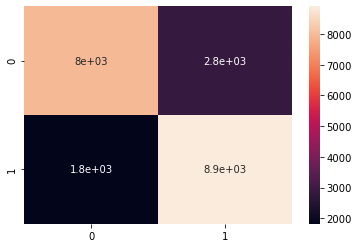

Confusion Matrix is
 [[7977 2822]
 [1820 8900]]


In [135]:
y_pred_XGB = xgb_model.predict(X_test)
CM = confusion_matrix(y_test, y_pred_XGB)

#sns.heatmap(CM, center=True)
sns.heatmap(CM, annot=True)
plt.show()

print('Confusion Matrix is\n', CM)

In [136]:
print("Accuracy:...   ",accuracy_score(y_test, y_pred_XGB))
print("Precision:...   ",precision_score(y_test, y_pred_XGB))
print("Recall:...   ",recall_score(y_test, y_pred_XGB))
print("F1-score:...   ",f1_score(y_test, y_pred_XGB))

Accuracy:...    0.7842836563037315
Precision:...    0.7592560996416994
Recall:...    0.8302238805970149
F1-score:...    0.7931556902236877


0.7844516939794038

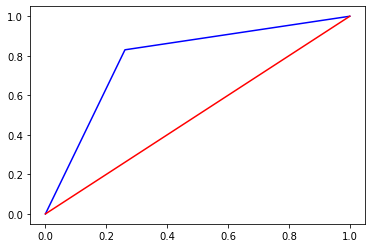

In [137]:
fpr,tpr,thresholds =  roc_curve(y_test,y_pred_XGB)
plt.plot(fpr,tpr,"b")
plt.plot([0,1],[0,1],"r-")
roc_auc_score(y_test,y_pred_XGB)

In [138]:
from sklearn.model_selection import cross_val_score
scores_cv = cross_val_score(xgb_model,X_train,y_train,cv=5)
scores_cv

array([0.78432715, 0.78469403, 0.7849849 , 0.78472808, 0.78927737])

In [139]:
import numpy as np
np.mean(scores_cv)

0.7856023063893536

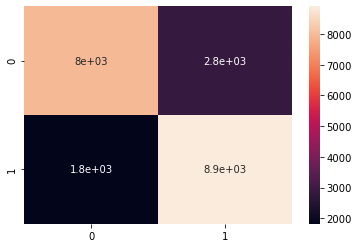

Confusion Matrix is
 [[7977 2822]
 [1820 8900]]


In [140]:
y_pred_XGB = xgb_model.predict(X_test)
CM = confusion_matrix(y_test, y_pred_XGB)

#sns.heatmap(CM, center=True)
sns.heatmap(CM, annot=True)
plt.show()

print('Confusion Matrix is\n', CM)

In [141]:
print("Accuracy:...   ",accuracy_score(y_test, y_pred_XGB))
print("Precision:...   ",precision_score(y_test, y_pred_XGB))
print("Recall:...   ",recall_score(y_test, y_pred_XGB))
print("F1-score:...   ",f1_score(y_test, y_pred_XGB))

Accuracy:...    0.7842836563037315
Precision:...    0.7592560996416994
Recall:...    0.8302238805970149
F1-score:...    0.7931556902236877


0.7844516939794038

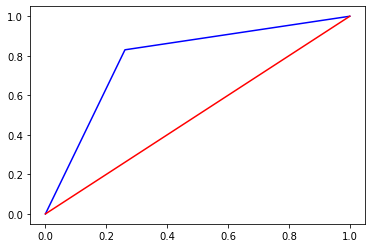

In [142]:
fpr,tpr,thresholds =  roc_curve(y_test,y_pred_XGB)
plt.plot(fpr,tpr,"b")
plt.plot([0,1],[0,1],"r-")
roc_auc_score(y_test,y_pred_XGB)

Utilisation du modèle RandomForest

In [144]:
from sklearn.ensemble import RandomForestClassifier

In [145]:
rf_Model = RandomForestClassifier()
rf_Model.fit(X_train,y_train)
print('Random Forest Train Score is : ' , rf_Model.score(X_train, y_train))
print('Random Forest Test Score is : ' , rf_Model.score(X_test, y_test))

Random Forest Train Score is :  0.9901505905487737
Random Forest Test Score is :  0.9674241368093313


matrice de confusion

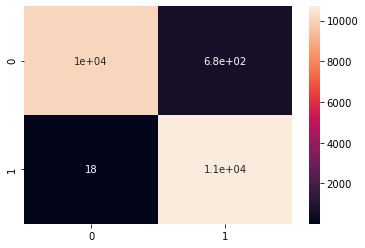

Confusion Matrix is
 [[10116   683]
 [   18 10702]]


In [146]:
y_pred_RF = rf_Model.predict(X_test)
CM_RF = confusion_matrix(y_test, y_pred_RF)

#sns.heatmap(CM_RF, center=True)
sns.heatmap(CM_RF, annot=True)

plt.show()

print('Confusion Matrix is\n', CM_RF)

In [147]:
print("Accuracy:...   ",accuracy_score(y_test, y_pred_RF))
print("Precision:...   ",precision_score(y_test, y_pred_RF))
print("Recall:...   ",recall_score(y_test, y_pred_RF))
print("F1-score:...   ",f1_score(y_test, y_pred_RF))

Accuracy:...    0.9674241368093313
Precision:...    0.9400087834870443
Recall:...    0.998320895522388
F1-score:...    0.968287717710925


0.9675371493076335

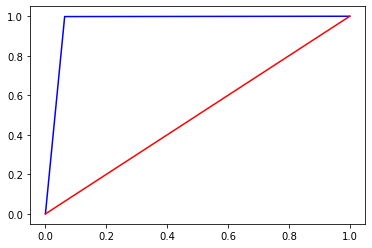

In [148]:
fpr,tpr,thresholds =  roc_curve(y_test,y_pred_RF)
plt.plot(fpr,tpr,"b")
plt.plot([0,1],[0,1],"r-")
roc_auc_score(y_test,y_pred_RF)

Utilisation du DecisionTree

In [150]:
from sklearn.tree import DecisionTreeClassifier

In [151]:
dt_Model = DecisionTreeClassifier()
dt_Model.fit(X_train,y_train)
print('Decision Tree Train Score is : ' , dt_Model.score(X_train, y_train))
print('Decision Tree Test Score is : ' , dt_Model.score(X_test, y_test))

Decision Tree Train Score is :  0.9901554822346199
Decision Tree Test Score is :  0.9592453180909893


Matrice de confusion

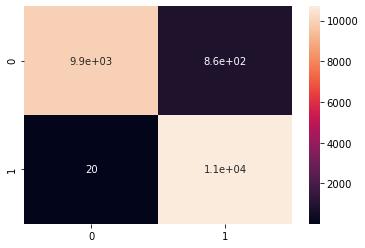

Confusion Matrix is
 [[ 9942   857]
 [   20 10700]]


In [152]:
y_pred_DT = dt_Model.predict(X_test)
CM_DT = confusion_matrix(y_test, y_pred_DT)

#sns.heatmap(CM_RF, center=True)
sns.heatmap(CM_DT, annot=True)

plt.show()

print('Confusion Matrix is\n', CM_DT)

In [153]:
print("Accuracy:...   ",accuracy_score(y_test, y_pred_DT))
print("Precision:...   ",precision_score(y_test, y_pred_DT))
print("Recall:...   ",recall_score(y_test, y_pred_DT))
print("F1-score:...   ",f1_score(y_test, y_pred_DT))

Accuracy:...    0.9592453180909893
Precision:...    0.9258458077355716
Recall:...    0.9981343283582089
F1-score:...    0.9606320420164295


0.9593875642161448

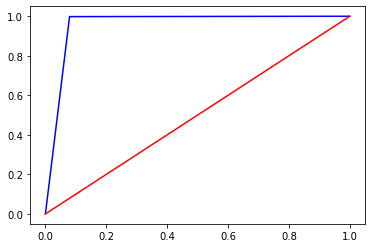

In [154]:
fpr,tpr,thresholds =  roc_curve(y_test,y_pred_DT)
plt.plot(fpr,tpr,"b")
plt.plot([0,1],[0,1],"r-")
roc_auc_score(y_test,y_pred_DT)